<a href="https://colab.research.google.com/github/AIAlchemy1/Generative-AI/blob/main/07_Encoder_Decoder_Attention/Encoder_Decoder_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sequence-to-Sequence Models (Encoder Decoder Attention)

In this project, I will take a look at sequence-to-sequence model based on encoder-decoder architecture.

Encoder-decoder models are widely used for machine translation. I will train encoder-decoder model for a similar task to transform various formats of dates into unified format.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSAmbScvsx2eaYSIy5r9xZW0ywNzKLILOV76Q&usqp=CAU)

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset


First let's generate a dataset of dates with format templates. Dataset item would contain a pair of dates: a date in one of the input formats and a date in target format. For example:
```
  18.11.2023   >   18-11-2023

  Aug 7th 2022   >   07-08-2022
```




In [4]:
import datetime
from random import randrange
from datetime import timedelta

In [5]:
random.seed(42)
torch.manual_seed(42)

In [6]:
def get_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return (start + timedelta(seconds=random_second)).replace(hour=0, minute = 0, second=0)


FORMATS = ['%d %b %Y', '%d %B %Y', '%B %dth, %Y', '%b %d, %Y',
           '%d/%m/%Y', '%d/%m/%y', '%d-%b-%y', '%d.%m.%Y']

TARGET_FORMAT = '%d-%m-%Y'

def get_dataset(fst_dt, snd_dt, fmt_dt, size=10000):
    fst_d = datetime.datetime.strptime(fst_dt, fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, fmt_dt)
    dataset = []
    for i in range(size):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(fst_d, snd_d)
        t = (datetime.datetime.strftime(rand_dt, date_format),
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT))
        dataset.append(t)
    return dataset

dataset = get_dataset('1/1/2022', '1/1/2024', '%m/%d/%Y')

In [7]:
dataset[:10]

[('20 January 2022', '20-01-2022'),
 ('10/07/2022', '10-07-2022'),
 ('Apr 19, 2022', '19-04-2022'),
 ('10 June 2023', '10-06-2023'),
 ('04 April 2023', '04-04-2023'),
 ('25-Jan-22', '25-01-2022'),
 ('14 Mar 2022', '14-03-2022'),
 ('Jun 30, 2022', '30-06-2022'),
 ('12 Mar 2023', '12-03-2023'),
 ('Jul 11, 2023', '11-07-2023')]

I will define additional class to build word-to-index and index-to-word mappings for the dataset.



In [8]:
SOS_token = 0
EOS_token = 1

# word corresponds to character
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [9]:
def readLangs(lang1, lang2):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang


def prepareData(lang1, lang2, start_date, end_date, dataset_size=10000):
    print(start_date, end_date)
    pairs = get_dataset(start_date, end_date, '%m/%d/%Y', dataset_size)
    input_lang, output_lang = readLangs(lang1, lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('human', 'iso', '1/1/2022', '1/1/2024')
print(random.choice(pairs))

1/1/2022 1/1/2024
human 43
iso 13
('Mar 13, 2023', '13-03-2023')


In [10]:
# define max_length as (maximum sequence length + 1 special char for EOS)
MAX_LENGTH = max(map(lambda x: len(x[0]), dataset)) + 1

In [11]:
print(input_lang.word2index)

{'O': 2, 'c': 3, 't': 4, 'o': 5, 'b': 6, 'e': 7, 'r': 8, ' ': 9, '0': 10, '2': 11, 'h': 12, ',': 13, '5': 14, '/': 15, 'M': 16, 'a': 17, 'y': 18, '8': 19, '3': 20, 'J': 21, 'u': 22, 'n': 23, '1': 24, '6': 25, '9': 26, '7': 27, '-': 28, 'N': 29, 'v': 30, '4': 31, 'S': 32, 'p': 33, 'm': 34, '.': 35, 'D': 36, 'l': 37, 'A': 38, 'g': 39, 's': 40, 'i': 41, 'F': 42}


In [12]:
print(output_lang.word2index)

{'0': 2, '2': 3, '-': 4, '1': 5, '5': 6, '8': 7, '3': 8, '6': 9, '9': 10, '7': 11, '4': 12}


### Encoder
The model will consist of RNN encoder and RNN decoder blocks:
- Encoder reads a sentence and outputs encoder representation,
- Decoder takes encoder's hidden state (also called *context*) as initial hidden vector and generates output sentence.

In the end of the input sentence I add `<EOS>` token, encoder hidden state after this token will be passed to decoder.

Decoder takes `<SOS>` token as an input and encoder final hidden state as initial hidden state.

Here is an example of the encoder-decoder architecture applied for machine translation:
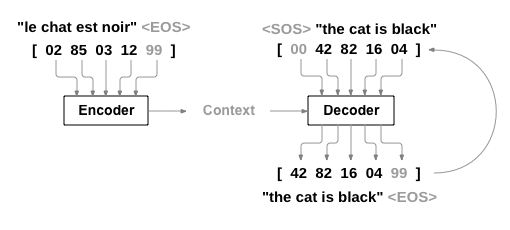

Encoder contains two layers:
- Embedding layer transforms ids of input tokens into vector representations,
- GRU layer returns encodings of input tokens that would be passed to decoder.  

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder



Let's start with basic RNN decoder. Simple decoder uses encoder output as initial hidden state and `<SOS>` token as the first token of the output sequence. Then it starts to generate output sequence token by token as language model.

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden


### Training


In [15]:
# additional functions to add special tokens and transform sentences to tensors
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in list(sentence)]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Before I start implementing train function, I need to consider a concept of *teacher forcing* used for sequence generation in decoder. Each step decoder takes input and hiddent state from the previous step and makes prediction for the next element of the sequence. There are two options what I can use as an input for next step of the decoder: token generated by decoder (decoder's output on the previous step) or target token on this position (from ground truth output sequence). Teacher forcing suggests to use target token in the fixed part of cases so that the model could sometimes look at correct previous token to produce next one and the same time use its own predictions for generating process.
![](https://mblogthumb-phinf.pstatic.net/MjAyMDAxMzFfMTcg/MDAxNTgwMzk4NTc3MzE2.rfhepBTuNa7UuGl7t4O2AAtVytd3Yd2d731im7KZ_jwg.kO58sY_DL9sBLx1LlZzq5A3hAplPA0gJA-6q4ZDr7Owg.PNG.sooftware/image.png?type=w800)

In [16]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # use_teacher_forcing = False
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      # with teacher forcing use next token from target as next input token
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # without teacher forcing use model's prediction as next input token
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Let's add a function to plot the results of training.

In [18]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Now I will implement evaluation function to generate transformed sequence for the input using trained encoder and decoder.

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [20]:
# evaluate random pair of sentences from training set
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

(500 7%) 1.1836
(1000 14%) 0.7017
(1500 21%) 0.6311
(2000 28%) 0.6164
(2500 35%) 0.5713
(3000 42%) 0.5001
(3500 50%) 0.4441
(4000 57%) 0.3747
(4500 64%) 0.3424
(5000 71%) 0.2816
(5500 78%) 0.2242
(6000 85%) 0.1944
(6500 92%) 0.1602
(7000 100%) 0.1292


<Figure size 640x480 with 0 Axes>

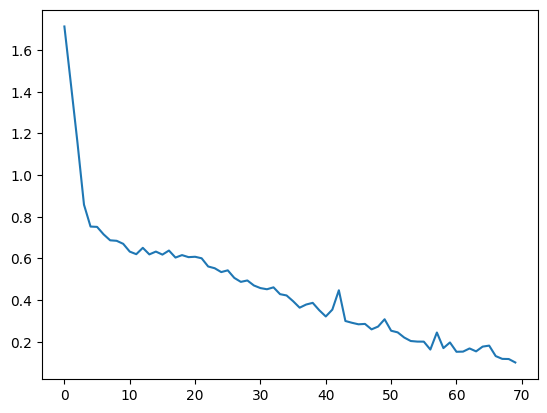

In [21]:
hidden_size = 256
encoder0 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder0 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder0, decoder0, 7000, print_every=500)

In [22]:
evaluateRandomly(encoder0, decoder0)

> 09/10/22
= 09-10-2022
< 09-01-2022<EOS>

> 16.03.2023
= 16-03-2023
< 16-03-2023<EOS>

> 29.01.2022
= 29-01-2022
< 29-01-2022<EOS>

> 24.09.2023
= 24-09-2023
< 24-04-2023<EOS>

> 16/12/23
= 16-12-2023
< 16-12-2023<EOS>

> 03 March 2022
= 03-03-2022
< 03-03-2022<EOS>

> 11/04/23
= 11-04-2023
< 11-04-2023<EOS>

> Apr 15, 2023
= 15-04-2023
< 15-04-2023<EOS>

> 30.03.2022
= 30-03-2022
< 30-03-2022<EOS>

> 05-Feb-22
= 05-02-2022
< 05-02-2022<EOS>



In [23]:
''.join(evaluate(encoder0, decoder0, 'Apr 02, 2023'))

'04-04-2023<EOS>'

In [24]:
''.join(evaluate(encoder0, decoder0, '08.10.2023'))

'08-01-2023<EOS>'

In [25]:
''.join(evaluate(encoder0, decoder0, '08/10/23'))

'08-01-2023<EOS>'

In [26]:
''.join(evaluate(encoder0, decoder0, '08/03/23'))

'08-03-2023<EOS>'

In [27]:
''.join(evaluate(encoder0, decoder0, '08.09.23'))

'09-08-2023<EOS>'

In [28]:
''.join(evaluate(encoder0, decoder0, '10 June 2022'))

'10-06-2022<EOS>'

### Attention Decoder

Attention mechanism allows to consider different positions of the input sentence for generating output at each step of the decoder.

- At each decoder step attention score are computed using decoder hidden state and all encoder outputs. The scores show how important is each input token for the current position in decoder.
- Softmax is applied to attention scores to get attention weights.
- Attention output is calculated as a weighted sum of encoder representations with attention weights.


In [29]:
# Luong attention score

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def general_score(self, hidden, encoder_output):
        score = self.attn(encoder_output)
        return torch.sum(hidden * score, dim=2)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.general_score(hidden, encoder_outputs), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [30]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      # with teacher forcing use next token from target as next input token
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # without teacher forcing use model's prediction as next input token
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [32]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [33]:
# evaluate random pair of sentences from training set
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

(500 7%) 1.1923
(1000 14%) 0.6829
(1500 21%) 0.5398
(2000 28%) 0.6819
(2500 35%) 0.4869
(3000 42%) 0.3623
(3500 50%) 0.2778
(4000 57%) 0.2044
(4500 64%) 0.1694
(5000 71%) 0.0965
(5500 78%) 0.0556
(6000 85%) 0.0347
(6500 92%) 0.0244
(7000 100%) 0.0197


<Figure size 640x480 with 0 Axes>

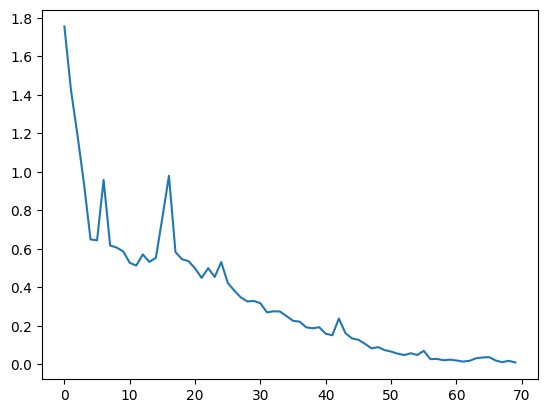

In [34]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 7000, print_every=500)

In [35]:
evaluateRandomly(encoder1, attn_decoder1)

> 09/02/22
= 09-02-2022
< 09-02-2022<EOS>

> 27 May 2023
= 27-05-2023
< 27-05-2023<EOS>

> 08 June 2023
= 08-06-2023
< 08-06-2023<EOS>

> 04 February 2023
= 04-02-2023
< 04-02-2023<EOS>

> 04/03/22
= 04-03-2022
< 04-03-2022<EOS>

> 22 Feb 2022
= 22-02-2022
< 22-02-2022<EOS>

> 12/03/22
= 12-03-2022
< 12-03-2022<EOS>

> 29 April 2023
= 29-04-2023
< 29-04-2023<EOS>

> 09 February 2023
= 09-02-2023
< 09-02-2023<EOS>

> 25/06/23
= 25-06-2023
< 25-06-2023<EOS>



In [36]:
''.join(evaluate(encoder1, attn_decoder1, 'Apr 02, 2023')[0])


'02-04-2023<EOS>'

In [37]:
''.join(evaluate(encoder1, attn_decoder1, '08.10.2023')[0])


'08-10-2023<EOS>'

In [38]:
''.join(evaluate(encoder1, attn_decoder1, '08/10/23')[0])


'08-10-2023<EOS>'

In [39]:
''.join(evaluate(encoder1, attn_decoder1, '08.09.23')[0])


'08-09-2023<EOS>'

In [40]:
''.join(evaluate(encoder1, attn_decoder1, '10 June 2022')[0])


'10-06-2022<EOS>'

### Visualize Attention

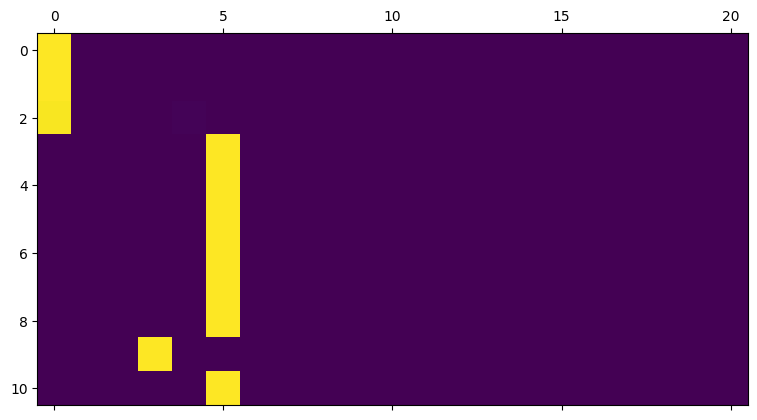

In [41]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05.03.2022")
plt.matshow(attentions.numpy())

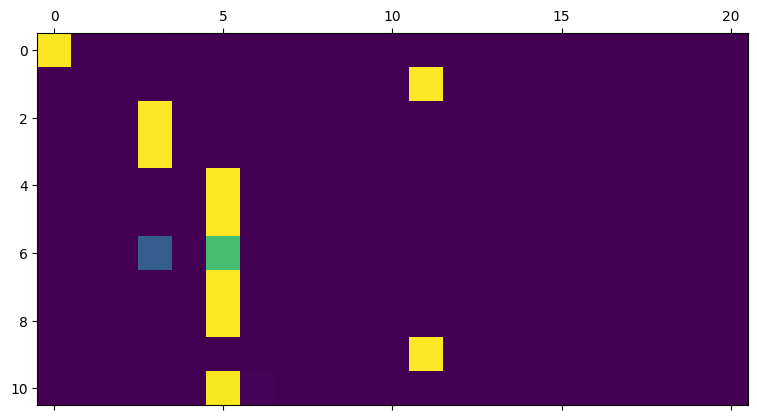

In [42]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "October 5 2022")
plt.matshow(attentions.numpy())

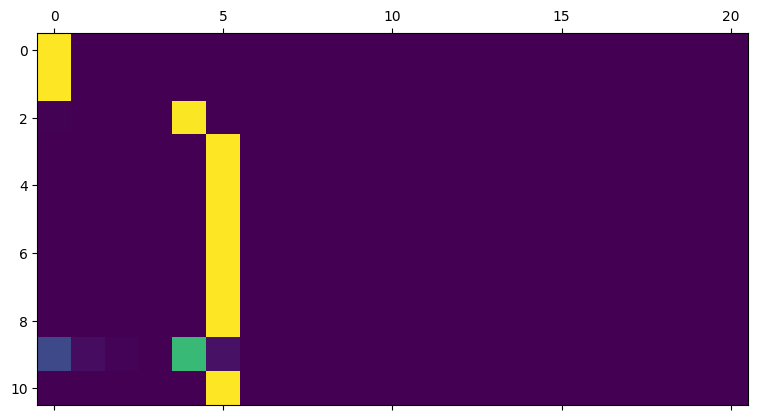

In [43]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05/10/22")
plt.matshow(attentions.numpy())

In [44]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ''.join(list(output_words)))
    showAttention(input_sentence, output_words, attentions)

input = 05 October 2022
output = 05-10-2022<EOS>


<ipython-input-44-fe05f51e0898>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-44-fe05f51e0898>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


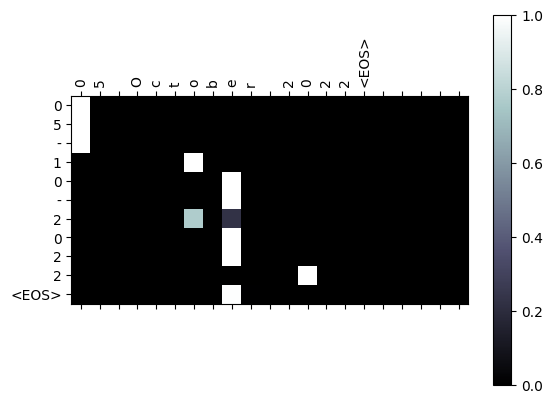

In [45]:
evaluateAndShowAttention("05 October 2022", encoder1, attn_decoder1)

input = 04/01/2022
output = 04-01-2022<EOS>


<ipython-input-44-fe05f51e0898>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-44-fe05f51e0898>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


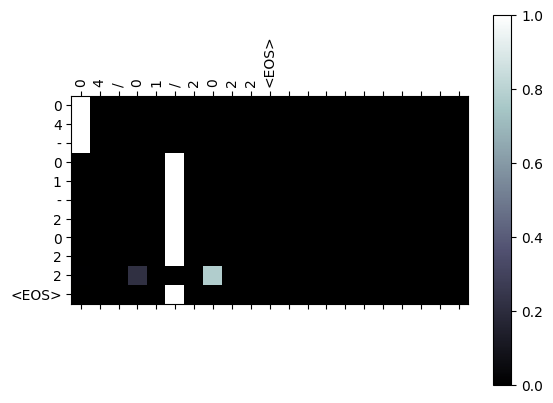

In [46]:
evaluateAndShowAttention("04/01/2022", encoder1, attn_decoder1)

input = December 13th, 2022
output = 13-12-2022<EOS>


<ipython-input-44-fe05f51e0898>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-44-fe05f51e0898>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


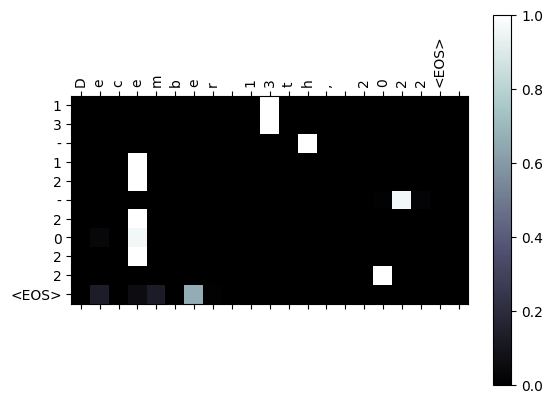

In [47]:
evaluateAndShowAttention("December 13th, 2022", encoder1, attn_decoder1)

input = Feb 09, 2022
output = 09-02-2022<EOS>


<ipython-input-44-fe05f51e0898>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-44-fe05f51e0898>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


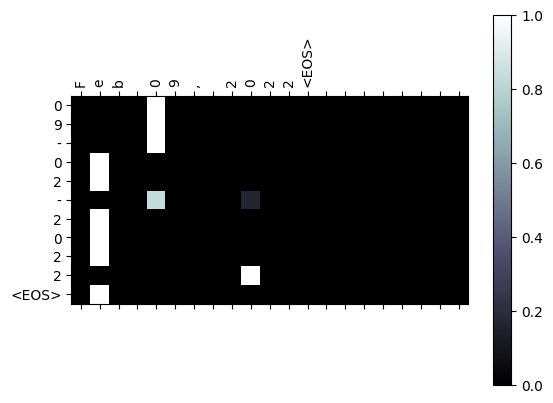

In [48]:
evaluateAndShowAttention("Feb 09, 2022", encoder1, attn_decoder1)

### Evaluation

In [49]:
dataset_test = get_dataset('1/1/2022', '1/1/2024', '%m/%d/%Y', 100)

In [50]:
len(dataset_test)

100

In [51]:
def accuracy_on_test(encoder, decoder, dataset_test):
    i = 0
    n = 0
    for pair in dataset_test:
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        # output_sentence - pred
        n += 1
        i += int(output_sentence[:10]== pair[1][:10])
    return i*1. /n


**BLEU Measure**

In [52]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 3.3 MB/s eta 0:00:00


In [53]:
import sacrebleu

def bleu_on_test(encoder, decoder, dataset_test):
    i = 0
    n = 0
    translated = []
    target = []
    for pair in dataset_test:
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        # output_sentence - pred
        translated.append(output_sentence[:10])
        target.append(pair[1])
    bleu = sacrebleu.corpus_bleu(translated, [target])
    return bleu.score

In [54]:
accuracy = accuracy_on_test(encoder1, attn_decoder1, dataset_test)
print(accuracy)

1.0


In [55]:
bleu = bleu_on_test(encoder1, attn_decoder1, dataset_test)
print(bleu)

100.00000000000004


### Different Attention Scores

In [56]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, method='general', dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.method = method

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        score = self.attn(encoder_output)
        return torch.sum(hidden * score, dim=2)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        if self.method == 'general':
            attn_weights = F.softmax(self.general_score(hidden, encoder_outputs), dim=1)
        elif self.method == 'dot':
            attn_weights = F.softmax(self.dot_score(hidden, encoder_outputs), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Let's train a model with a new version of attention in decoder.

(500 7%) 1.1279
(1000 14%) 0.6787
(1500 21%) 0.8645
(2000 28%) 0.6093
(2500 35%) 0.5431
(3000 42%) 0.4768
(3500 50%) 0.4686
(4000 57%) 0.3469
(4500 64%) 0.2767
(5000 71%) 0.2376
(5500 78%) 0.2014
(6000 85%) 0.1580
(6500 92%) 0.1301
(7000 100%) 0.0964


<Figure size 640x480 with 0 Axes>

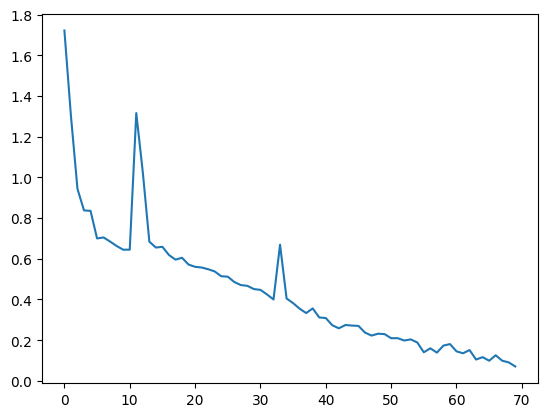

In [57]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, method='dot',dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 7000, print_every=500)

In [ ]:
accuracy = accuracy_on_test(encoder1, attn_decoder1, dataset_test)
bleu = bleu_on_test(encoder1, attn_decoder1, dataset_test)

print(accuracy, bleu)

0.82 90.77265505148486


Now we can check how attention weights changed with new decoder.



input = May 10th, 2022
output = 10-05-2022<EOS>


<ipython-input-44-fe05f51e0898>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-44-fe05f51e0898>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


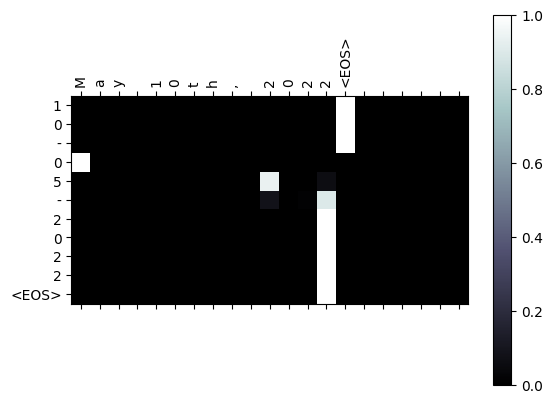

In [ ]:
evaluateAndShowAttention("May 10th, 2022", encoder1, attn_decoder1)